# COVID Global Forecast: SIR model + ML regressions

In the context of the global COVID-19 pandemic, Kaggle has launched several challenges in order to provide useful insights that may answer some of the open scientific questions about the virus. This is the case of the [COVID19 Global Forecasting](https://www.kaggle.com/c/covid19-global-forecasting-week-1), in which participants are encouraged to fit worldwide data in order to predict the pandemic evolution, hopefully helping to determine which factors impact the transmission behavior of COVID-19.

This notebook is a fork of [Patrick Sanchez' work](https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions), slimmed down, reduced and applied to Norway by me in an effort to explore ML forecasting in general and the spreading of viral disease in particular.

For more on the SIR model, I refer to [this video by Grant Sanderson](https://youtu.be/gxAaO2rsdIs). 

**TABLE OF CONTENTS**

1. [Exploratory data analysis (EDA)](#section1)

    1.1. [COVID-19 global tendency excluding China](#section11)
    
2. [SIR model](#section2)

    2.1. [Implementing the SIR model](#section21)
    
    2.2. [Fit SIR parameters to real data](#section22)
    
3. [Data enrichment](#section3)

    3.1. [Join data, filter dates and clean missings](#section31)
    
    3.2. [Compute lags and trends](#section32)
    
    3.3. [Add country details](#section33)
    
4. [Predictions for the late stages of the transmission](#section5)

    4.1. [Logistic curve fit](#section51)
    
    4.2. [Logistic curve fit for all countries](#section52)
    
    4.3. [ARIMA](#section53)
    


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# 1. Exploratory data analysis (EDA) <a id="section1"></a>

First of all, let's take a look on the data structure:

In [2]:
submission_example = pd.read_csv("../input/covid19-global-forecasting-week-4/submission.csv")
test = pd.read_csv("../input/covid19-global-forecasting-week-4/test.csv")
train = pd.read_csv("../input/covid19-global-forecasting-week-4/train.csv")
train.Province_State.fillna("None", inplace=True)
display(train.head(5))
display(train.describe())
print("Number of Country_Region: ", train['Country_Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", train.loc[train['Province_State']!='None']['Country_Region'].unique())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,None,Afghanistan,2020-01-22,0.0,0.0
1,2,None,Afghanistan,2020-01-23,0.0,0.0
2,3,None,Afghanistan,2020-01-24,0.0,0.0
3,4,None,Afghanistan,2020-01-25,0.0,0.0
4,5,None,Afghanistan,2020-01-26,0.0,0.0


,Id,ConfirmedCases,Fatalities
count,25353.000000,25353.000000,25353.000000
mean,17825.000000,1003.824518,50.392853
std,10300.683266,7542.589521,592.843013
min,1.000000,0.000000,0.000000
25%,8913.000000,0.000000,0.000000
50%,17825.000000,1.000000,0.000000
75%,26737.000000,93.000000,1.000000
max,35649.000000,181026.000000,19468.000000


Number of Country_Region:  184
Dates go from day 2020-04-11 to day 2020-01-22 , a total of 81 days
Countries with Province/State informed:  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


The dataset covers 163 countries and almost 2 full months from 2020, which is enough data to get some clues about the pandemic. Let's see a few plots of the worldwide tendency to see if we can extract some insights:

Text(0.5, 0, 'Date')

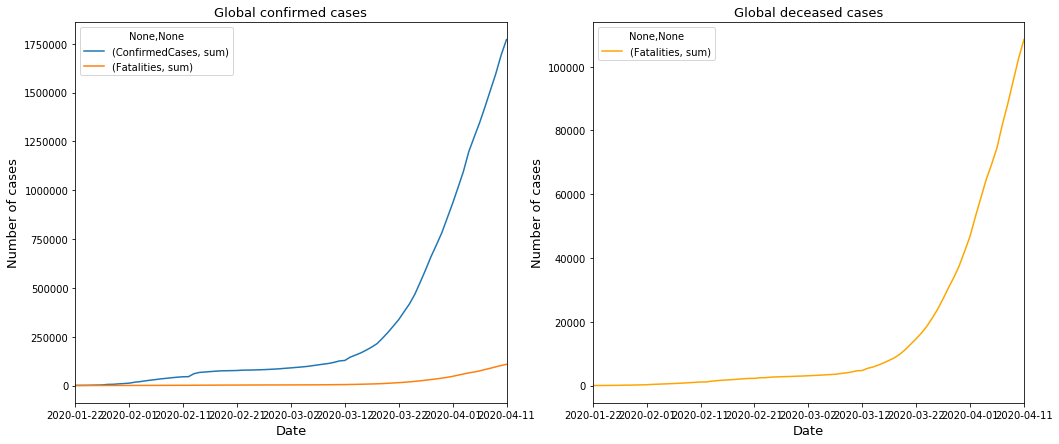

In [3]:
#confirmed_country = train.groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country = train.groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

**Observations**: The global curve shows a rich fine structure, but these numbers are strongly affected by the vector zero country, China. Given that COVID-19 started there, during the initial expansion of the virus there was no reliable information about the real infected cases. In fact,  the criteria to consider infection cases was modified around 2020-02-11, which strongly perturbed the curve as you can see from the figure. 

## 1.1. COVID-19 global tendency excluding China <a id="section11"></a>

Since details of the initial breakthrough strongly interfere with the results, it's recomended to analyze China independently. Let's first see the results without China: 

Text(0.5, 0, 'Date')

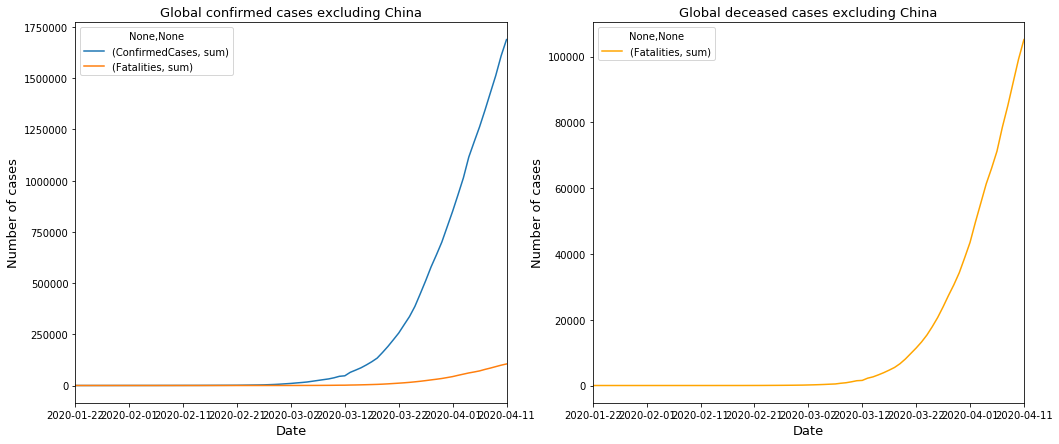

In [4]:
#confirmed_country_noChina = train[train['Country_Region']!='China'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_noChina = train[train['Country_Region']!='China'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date_noChina.plot(ax=ax1)
ax1.set_title("Global confirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

**Observations**: In this case the general behavior looks cleaner, and in fact the curve resembles a typical epidemiology model like [SIR](http://mat.uab.cat/matmat/PDFv2013/v2013n03.pdf). SIR models present a large increasing in the number of infections that, once it reaches the maximum of the contagion, decreases with a lower slope. For comparison, a SIR simulation from section [2. SIR model](#section2):

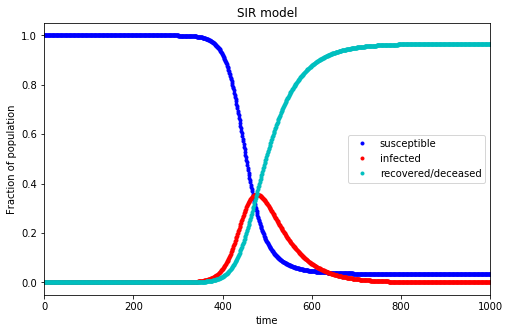

# 2. SIR model <a id="section2"></a>

We have seen some general behavior of the virus in agregated data, for the country where the coronavirus was originated and for four other interesting countries. There's a lot of information to be extracted from this data; for example, we haven't analyzed the effects of long/lat of countries. However, since our main purpose is to develop a predective model in order to understand the key factors that impact the COVID-19 transmission, I'll move on to one of the most famous epidemiologic models: SIR. 

SIR is a simple model that considers a population that belongs to one of the following states:
1. **Susceptible (S)**. The individual hasn't contracted the disease, but she can be infected due to transmisison from infected people
2. **Infected (I)**. This person has contracted the disease
3. **Recovered/Deceased (R)**. The disease may lead to one of two destinies: either the person survives, hence developing inmunity to the disease, or the person is deceased. 

<img src="https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png" width="500px">
Image by Kai Sasaki from [lewuathe.com](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html)

There are many versions of this model, considering birth and death (SIRD with demography), with intermediate states, etc. However, since we are in the early stages of the COVID-19 expansion and our interest is focused in the short term, we will consider that people develops immunity (in the long term, immunity may be lost and the COVID-19 may come back within a certain seasonality like the common flu) and there is no transition from recovered to the remaining two states. With this, the differential equations that govern the system are:

$$ {dS \over dt} = - {\beta S I \over N} $$

$$ {dI \over dt} = {\beta S I \over N} - \gamma I$$

$$ {dR \over dt} = \gamma I$$

Where $\beta$ is the contagion rate of the pathogen and $\gamma$ is the recovery rate.

## 2.1. Implementing the SIR model <a id="section21"></a>

SIR model can be implemented in many ways: from the differential equations governing the system, within a mean field approximation or running the dynamics in a social network (graph). For the sake of simplicity, I'vem chosen the first option, and we will simply run a numerical method (Runge-Kutta) to solve the differential equations system. 

The functions governing the dif.eqs. are:

In [5]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In order to solve the differential equations system, we develop a  4rth order [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) method:

In [6]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

And finally, to obtain the evolution of the disease we simply define the initial conditions and call the rk4 method:

In [7]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

Results obtained for N=world population, only one initial infected case, $\beta=0.3$, $\gamma=0.5$ and a leap pass $h_s = 0.1$ are shown below:

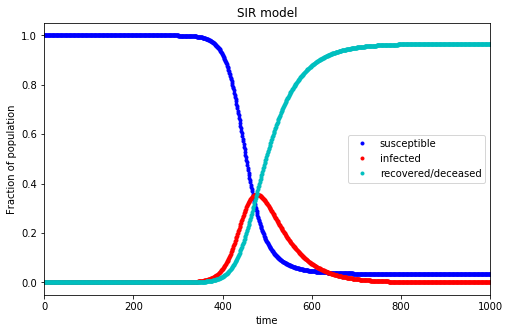

In [8]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

**Observations**: 
* The number of infected cases increases for a certain time period, and then eventually decreases given that individuals recover/decease from the disease
* The susceptible fraction of population decreases as the virus is transmited, to eventually drop to the absorbent state 0
* The oposite happens for the recovered/deceased case

Notice that different initial conditions and parameter values will lead to other scenarios, feel free to play with these numbers to study the system.

## 2.2. Fit SIR parameters to real data <a id="section22"></a>

The SIR model is purely theoretical, and we are interested into a real approximation of the COVID-19 expansion in order to extract insights and understand the transmission of the virus. Hence, we need to extract the $\beta$ and $\gamma$ paramaters for each case if we hope to be able to predict the evolution of the system.

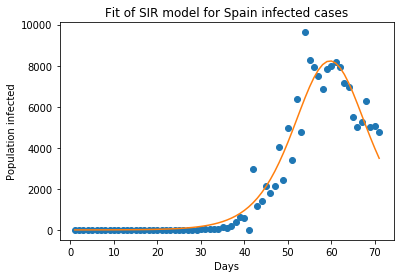

Optimal parameters: beta = 9.480455098347614  and gamma =  9.303082863104958


In [9]:
population = float(46750238)
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = train.loc[train['Country_Region']=='Spain'].ConfirmedCases.diff().fillna(0)
country_df = country_df[10:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Spain infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

**I'm not happy with the fit of parameters** and I want to work more on this, since I'm not properly reproducing the curves. I'll keep working on this for curiosity, but in the meanwhile I'll develop a data-centric approach to the prediction.

# 3. Data enrichment <a id="section3"></a>

Analyzing SIR simulations was meant to understand a model that approximately resembles the transmission mechanism of many virus, including the COVID-19. However, there are alternative methods that may prove being equally useful both to predict and to understand the pandemic evolution. Many of these methods rely on having rich data to extract conclusions and allow algorithms to extrapolate patterns in data, and that is exactly what we are going to do. 

Main workflow of this section:
1. Join data, filter dates and clean missings
2. Compute lags and trends
3. Add country details

**Disclaimer**: this data enrichment is not mandatory and we could end up not using all of the new features in our models. However I consider it a didactical step that will surely add some value, for example in an in-depth exploratory analysis.

## 3.1. Join data, filter dates and clean missings <a id="section31"></a>

First of all, we perform some pre-processing prepare the dataset, consisting on:

* **Join data**. Join train/test to facilitate data transformations
* **Filter dates**. According to the challenge conditions, remove ConfirmedCases and Fatalities post 2020-03-12. Create additional date columns
* **Missings**. Analyze and fix missing values

In [10]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
                 '2020-04-09', '2020-04-10']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-04-01', 'ConfirmedCases'] = 0
all_data.loc[all_data['Date'] >= '2020-04-01', 'Fatalities'] = 0
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province_State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

display(all_data)
display(all_data.loc[all_data['Date'] == '2020-04-01'])

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,2020
1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,2020
2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,2020
3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,2020
4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,2020
...,...,...,...,...,...,...,...,...,...,...,...
13454,-1.0,None,Zimbabwe,2020-05-10,0.0,0.0,13455.0,108,10,5,2020
13455,-1.0,None,Zimbabwe,2020-05-11,0.0,0.0,13456.0,109,11,5,2020
13456,-1.0,None,Zimbabwe,2020-05-12,0.0,0.0,13457.0,110,12,5,2020
13457,-1.0,None,Zimbabwe,2020-05-13,0.0,0.0,13458.0,111,13,5,2020


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year


**Observations**: 
* "ConfirmedCases" and "Fatalities" are now only informed for dates previous to 2020-03-12
* The dataset includes all countries and dates, which is required for the lag/trend step
* Missing values for "ConfirmedCases" and "Fatalities" have been replaced by 0, which may be dangerous if we do not remember it at the end of the process. However, since we will train only on dates previous to 2020-03-12, this won't impact our prediction algorithm
* A new column "Day" has been created, as a day counter starting from the first date

Double-check that there are no remaining missing values:

In [11]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
Id              0
Province_State  0
Country_Region  0
Date            0
ConfirmedCases  0
Fatalities      0
ForecastId      0
Day_num         0
Day             0
Month           0
Year            0


## 3.2. Compute lags and trends <a id="section32"></a>

Enriching a dataset is key to obtain good results. In this case we will apply 2 different transformations:

**Lag**. Lags are a way to compute the previous value of a column, so that the lag 1 for ConfirmedCases would inform the this column from the previous day. The lag 3 of a feature X is simply:
$$X_{lag3}(t) = X(t-3)$$


**Trend**. Transformig a column into its trend gives the natural tendency of this column, which is different from the raw value. The definition of trend I will apply is: 
$$Trend_{X} = {X(t) - X(t-1) \over X(t-1)}$$

The backlog of lags I'll apply is 14 days, while for trends is 7 days.  For ConfirmedCases and Fatalities:

In [12]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0)
    return df

def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df.groupby(['Country_Region', 'Province_State'])[column].shift(0, fill_value=0) - 
                                df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0))/df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0.001)
    return df


ts = time.time()
all_data = calculate_lag(all_data.reset_index(), range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  6.564117431640625


As you see, the process is really fast. An example of some of the lag/trend columns for Spain:

In [13]:
all_data[all_data['Country_Region']=='Spain'].iloc[40:50][['Id', 'Province_State', 'Country_Region', 'Date',
       'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num', 'ConfirmedCases_1',
       'ConfirmedCases_2', 'ConfirmedCases_3', 'Fatalities_1', 'Fatalities_2',
       'Fatalities_3']]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,Fatalities_1,Fatalities_2,Fatalities_3
15802,25349.0,None,Spain,2020-03-02,120.0,0.0,-1.0,40,84.0,45.0,32.0,0.0,0.0,0.0
15803,25350.0,None,Spain,2020-03-03,165.0,1.0,-1.0,41,120.0,84.0,45.0,0.0,0.0,0.0
15804,25351.0,None,Spain,2020-03-04,222.0,2.0,-1.0,42,165.0,120.0,84.0,1.0,0.0,0.0
15805,25352.0,None,Spain,2020-03-05,259.0,3.0,-1.0,43,222.0,165.0,120.0,2.0,1.0,0.0
15806,25353.0,None,Spain,2020-03-06,400.0,5.0,-1.0,44,259.0,222.0,165.0,3.0,2.0,1.0
15807,25354.0,None,Spain,2020-03-07,500.0,10.0,-1.0,45,400.0,259.0,222.0,5.0,3.0,2.0
15808,25355.0,None,Spain,2020-03-08,673.0,17.0,-1.0,46,500.0,400.0,259.0,10.0,5.0,3.0
15809,25356.0,None,Spain,2020-03-09,1073.0,28.0,-1.0,47,673.0,500.0,400.0,17.0,10.0,5.0
15810,25357.0,None,Spain,2020-03-10,1695.0,35.0,-1.0,48,1073.0,673.0,500.0,28.0,17.0,10.0
15811,25358.0,None,Spain,2020-03-11,2277.0,54.0,-1.0,49,1695.0,1073.0,673.0,35.0,28.0,17.0


## 3.3. Add country details <a id="section33"></a>

Variables like the total population of a country, the average age of citizens or the fraction of peoople living in cities may strongly impact on the COVID-19 transmission behavior. Hence, it's important to consider these factors. I'm using [Tanu's dataset](https://www.kaggle.com/tanuprabhu/population-by-country-2020) based on Web Scrapping for this purpose.

In [14]:
# Load countries data file
world_population = pd.read_csv("/kaggle/input/population-by-country-2020/population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)

# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
print("Joined dataset")
all_data = all_data.merge(world_population, left_on='Country_Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
display(all_data)

print("Encoded dataset")
# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country_Region'] = le.fit_transform(all_data['Country_Region'])
number_c = all_data['Country_Region']
countries = le.inverse_transform(all_data['Country_Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province_State'] = le.fit_transform(all_data['Province_State'])
number_p = all_data['Province_State']
province = le.inverse_transform(all_data['Province_State'])
province_dict = dict(zip(province, number_p)) 
display(all_data)

Cleaned country details dataset


,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1438116346,153,9388211,38,61
1,India,1377011281,464,2973190,28,35
2,US,330578810,36,9147420,38,83
3,Indonesia,272884327,151,1811570,30,56
4,Pakistan,219922471,287,770880,23,35
...,...,...,...,...,...,...
230,Montserrat,4991,50,100,19,10
231,Falkland Islands,3457,0,12170,19,66
232,Niue,1624,6,260,19,46
233,Tokelau,1353,136,10,19,0


Joined dataset


,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,...,0.0,0.0,0.0,0.0,Afghanistan,38728504.0,60.0,652860.0,18.0,25.0
1,1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,...,0.0,0.0,0.0,0.0,Afghanistan,38728504.0,60.0,652860.0,18.0,25.0
2,2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,...,0.0,0.0,0.0,0.0,Afghanistan,38728504.0,60.0,652860.0,18.0,25.0
3,3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,...,0.0,0.0,0.0,0.0,Afghanistan,38728504.0,60.0,652860.0,18.0,25.0
4,4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,...,0.0,0.0,0.0,0.0,Afghanistan,38728504.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35677,13454,-1.0,None,Zimbabwe,2020-05-10,0.0,0.0,13455.0,108,10,...,0.0,0.0,0.0,0.0,Zimbabwe,14814609.0,38.0,386850.0,19.0,38.0
35678,13455,-1.0,None,Zimbabwe,2020-05-11,0.0,0.0,13456.0,109,11,...,0.0,0.0,0.0,0.0,Zimbabwe,14814609.0,38.0,386850.0,19.0,38.0
35679,13456,-1.0,None,Zimbabwe,2020-05-12,0.0,0.0,13457.0,110,12,...,0.0,0.0,0.0,0.0,Zimbabwe,14814609.0,38.0,386850.0,19.0,38.0
35680,13457,-1.0,None,Zimbabwe,2020-05-13,0.0,0.0,13458.0,111,13,...,0.0,0.0,0.0,0.0,Zimbabwe,14814609.0,38.0,386850.0,19.0,38.0


Encoded dataset


,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,1.0,83,0,2020-01-22,0.0,0.0,-1.0,0,22,...,0.0,0.0,0.0,0.0,0.0,38728504.0,60.0,652860.0,18.0,25.0
1,1,2.0,83,0,2020-01-23,0.0,0.0,-1.0,1,23,...,0.0,0.0,0.0,0.0,0.0,38728504.0,60.0,652860.0,18.0,25.0
2,2,3.0,83,0,2020-01-24,0.0,0.0,-1.0,2,24,...,0.0,0.0,0.0,0.0,0.0,38728504.0,60.0,652860.0,18.0,25.0
3,3,4.0,83,0,2020-01-25,0.0,0.0,-1.0,3,25,...,0.0,0.0,0.0,0.0,0.0,38728504.0,60.0,652860.0,18.0,25.0
4,4,5.0,83,0,2020-01-26,0.0,0.0,-1.0,4,26,...,0.0,0.0,0.0,0.0,0.0,38728504.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35677,13454,-1.0,83,183,2020-05-10,0.0,0.0,13455.0,108,10,...,0.0,0.0,0.0,0.0,0.0,14814609.0,38.0,386850.0,19.0,38.0
35678,13455,-1.0,83,183,2020-05-11,0.0,0.0,13456.0,109,11,...,0.0,0.0,0.0,0.0,0.0,14814609.0,38.0,386850.0,19.0,38.0
35679,13456,-1.0,83,183,2020-05-12,0.0,0.0,13457.0,110,12,...,0.0,0.0,0.0,0.0,0.0,14814609.0,38.0,386850.0,19.0,38.0
35680,13457,-1.0,83,183,2020-05-13,0.0,0.0,13458.0,111,13,...,0.0,0.0,0.0,0.0,0.0,14814609.0,38.0,386850.0,19.0,38.0


# 4. Predictions for the early stages of the transmission <a id="section4"></a>

Our obective in this section consists on  predicting the evolution of the expansion from a data-centric perspective, like any other regression problem. To do so, remember that the challenge specifies that submissions on the public LB shouldn only contain data previous to 2020-03-26.

Models to apply:
1. Linear Regression for one country
2. Linear Regression for all countries (method 1)
3. Linear Regression for all countries (method 2)

In [15]:
# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country_Region', 'Province_State', 'ConfirmedCases', 'Fatalities', 
       'Day_num']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Split data into train/test
def split_data(df, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim , 'ForecastId'] = -1
    df = df[df['Day_num']<=test_lim]
    
    # Train set
    x_train = df[df.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = df[df.ForecastId == -1]['ConfirmedCases']
    y_train_2 = df[df.ForecastId == -1]['Fatalities']

    # Test set
    x_test = df[df.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# Submission function
def get_submission(df, target1, target2):
    
    prediction_1 = df[target1]
    prediction_2 = df[target2]

    # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    submission = pd.DataFrame({
        "ForecastId": df['ForecastId'].astype('int32'), 
        "ConfirmedCases": prediction_1, 
        "Fatalities": prediction_2
    })
    submission.to_csv('submission.csv', index=False)

Let's try to see results when training with a single country:

* **Spain**

In [16]:
# Select train (real) data from March 1 to March 22nd
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                 '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', 
                 '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', 
                 '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10']

In [17]:
all_data.loc[all_data['Country_Region']==country_dict['Spain']][50:70]

,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
15812,18032,25359.0,83,156,2020-03-12,2277.0,55.0,-1.0,50,12,...,0.571429,0.964286,2.235294,4.500000,10.000000,46750879.0,94.0,498800.0,45.0,80.0
15813,18033,25360.0,83,156,2020-03-13,5232.0,133.0,-1.0,51,13,...,1.462963,2.800000,3.750000,6.823529,12.300000,46750879.0,94.0,498800.0,45.0,80.0
15814,18034,25361.0,83,156,2020-03-14,6391.0,195.0,-1.0,52,14,...,2.545455,2.611111,4.571429,5.964286,10.470588,46750879.0,94.0,498800.0,45.0,80.0
15815,18035,25362.0,83,156,2020-03-15,7798.0,289.0,-1.0,53,15,...,1.172932,4.254545,4.351852,7.257143,9.321429,46750879.0,94.0,498800.0,45.0,80.0
15816,18036,25363.0,83,156,2020-03-16,9942.0,342.0,-1.0,54,16,...,0.753846,1.571429,5.218182,5.333333,8.771429,46750879.0,94.0,498800.0,45.0,80.0
15817,18037,25364.0,83,156,2020-03-17,11748.0,533.0,-1.0,55,17,...,0.844291,1.733333,3.007519,8.690909,8.870370,46750879.0,94.0,498800.0,45.0,80.0
15818,18038,25365.0,83,156,2020-03-18,13910.0,623.0,-1.0,56,18,...,0.821637,1.155709,2.194872,3.684211,10.327273,46750879.0,94.0,498800.0,45.0,80.0
15819,18039,25366.0,83,156,2020-03-19,17963.0,830.0,-1.0,57,19,...,0.557223,1.426901,1.871972,3.256410,5.240602,46750879.0,94.0,498800.0,45.0,80.0
15820,18040,25367.0,83,156,2020-03-20,20410.0,1043.0,-1.0,58,20,...,0.674157,0.956848,2.049708,2.608997,4.348718,46750879.0,94.0,498800.0,45.0,80.0
15821,18041,25368.0,83,156,2020-03-21,25374.0,1375.0,-1.0,59,21,...,0.656627,1.207063,1.579737,3.020468,3.757785,46750879.0,94.0,498800.0,45.0,80.0


# 5. Predictions for the late stages of the transmission (under construction)<a id="section5"></a>

As the transmission progresses, **the exponential regime is left behind** and the Linear Regressor we developed begins to predict worse results. We were aware of this limitation, and now **alternative methods are required** in order to capture the new behavior.

I'd like to clarify that the aim of this section will be to predict the immediate future evolution of the number of cases, not to estimate when the peack of infections will happen or to which extent the COVID-19 will spread in each country. 

Models considered in this section:

1. Logistic curve fit

2. Logistic curve fit for all countries

3. ARIMA


## 5.1. Logistic curve fit <a id="section51"></a>

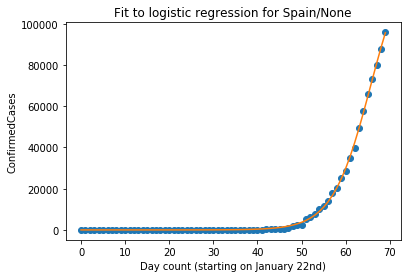

In [18]:
def logistic_function(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

def fit_logistic(all_data, country_name, province_name, train_lim, target):
    data_cp = all_data.loc[(all_data['Country_Region']==country_dict[country_name]) & (all_data['Province_State']==province_dict[province_name])]
    y = data_cp.loc[(data_cp['Day_num'])<=train_lim, target].astype(np.int32)
    x = list(range(0, len(y)))

    # Initial guess
    p0 = [0,1,1,0]

    (a_, b_, c_, d_), cov = optimize.curve_fit(logistic_function, x, y, bounds=(0, [500000., 10., 1000., 1000., ]), p0=p0, maxfev=10**9)
    y_fit = logistic_function(x, a_, b_, c_, d_)
    
    return x, y, y_fit, (a_, b_, c_, d_), cov

def plot_logistic(x, y, y_fit, country_name, province_name, target):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(x, y, 'o')
    ax.plot(x, y_fit, '-')
    ax.set_xlabel("Day count (starting on January 22nd)")
    ax.set_ylabel(target)
    ax.set_title("Fit to logistic regression for "+ country_name+"/"+province_name)


# Fit country to logistic curve
country_name = 'Spain'
province_name = 'None'
train_lim = 69
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')

* **Italy**

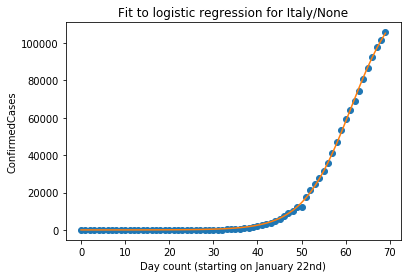

In [19]:
# Fit country to logistic curve
country_name = 'Italy'
province_name = 'None'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')

* **Germany**

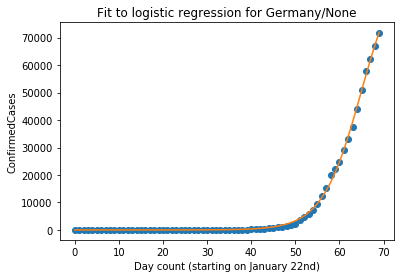

In [20]:
# Fit country to logistic curve
country_name = 'Germany'
province_name = 'None'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')

* **Albania**

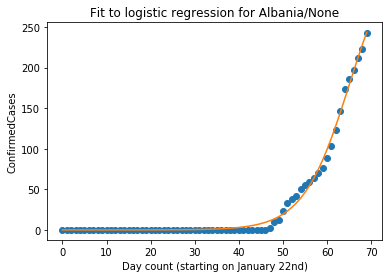

In [21]:
# Fit country to logistic curve
country_name = 'Albania'
province_name = 'None'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')

* **Norway**

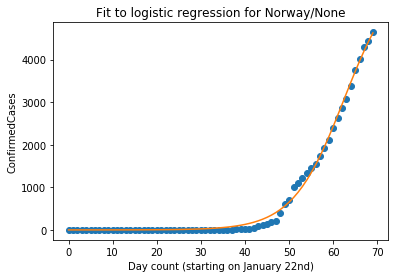

In [22]:
# Fit country to logistic curve
country_name = 'Norway'
province_name = 'None'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')

*** China/Hubei**

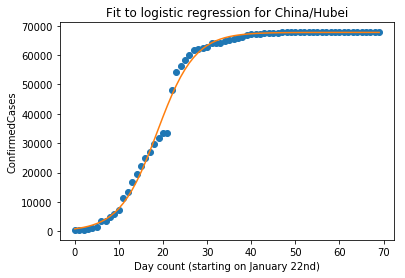

In [23]:
# Fit country to logistic curve
country_name = 'China'
province_name = 'Hubei'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')

## 5.2. Logistic curve fit for all countries <a id="section52"></a>

In [29]:

train_lim = 69
test_lim = 112

def logistic_forecast_allcountries(all_data, train, train_lim, test_lim):
    
    ts = time.time()
    data_pred = all_data[all_data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
    data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
    data_pred['Predicted_Fatalities'] = [0]*len(data_pred)

    # Main loop for countries
    for country_name in tqdm(train['Country_Region'].unique(), desc=f'Iterating through all countries'):
        for province_name in train[train['Country_Region']==country_name]['Province_State'].unique():
            
            # ConfirmedCases
            x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
            pred_1 = [logistic_function(t, a_, b_, c_, d_) for t in list(range(train_lim+1, test_lim+1))]
            data_pred.loc[((data_pred['Country_Region']==country_dict[country_name]) & (data_pred['Province_State']==province_dict[province_name])), 'Predicted_ConfirmedCases'] = pred_1

            # Fatalities
            x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'Fatalities')
            pred_2 = [logistic_function(t, a_, b_, c_, d_) for t in list(range(train_lim+1, test_lim+1))]
            data_pred.loc[((data_pred['Country_Region']==country_dict[country_name]) & (data_pred['Province_State']==province_dict[province_name])), 'Predicted_Fatalities'] = pred_2


    print("Logistic function fit for all countries finished in ", round(time.time() - ts, 2), " seconds")
    return data_pred
    
logistic_forecast = logistic_forecast_allcountries(all_data, train, train_lim, test_lim) 
get_submission(logistic_forecast, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')



Iterating through all countries:   0%|          | 0/184 [00:00<?, ?it/s]

Iterating through all countries:   1%|          | 2/184 [00:00<00:13, 13.32it/s]

Iterating through all countries:   2%|▏         | 4/184 [00:01<00:36,  4.94it/s]

Iterating through all countries:   3%|▎         | 6/184 [00:01<00:29,  6.00it/s]

Iterating through all countries:   4%|▍         | 8/184 [00:01<00:24,  7.24it/s]

Iterating through all countries:   5%|▍         | 9/184 [03:25<2:58:42, 61.27s/it]

Iterating through all countries:   6%|▌         | 11/184 [03:25<2:03:55, 42.98s/it]

Iterating through all countries:   7%|▋         | 13/184 [03:26<1:25:48, 30.11s/it]

Iterating through all countries:   8%|▊         | 15/184 [03:26<59:25, 21.10s/it]  

Iterating through all countries:   9%|▊         | 16/184 [06:49<3:32:22, 75.85s/it]

Iterating through all countries:  10%|▉         | 18/184 [06:50<2:26:57, 53.12s/it]

Iterating through all countries:  11%|█         | 20/184 [06:50<1:41:44, 37.22s/it]

It

Iterating through all countries:  83%|████████▎ | 153/184 [31:09<07:50, 15.18s/it]

Iterating through all countries:  84%|████████▎ | 154/184 [31:10<05:25, 10.86s/it]

Iterating through all countries:  85%|████████▍ | 156/184 [31:10<03:33,  7.63s/it]

Iterating through all countries:  86%|████████▌ | 158/184 [31:10<02:19,  5.36s/it]

Iterating through all countries:  86%|████████▋ | 159/184 [31:11<01:35,  3.83s/it]

Iterating through all countries:  88%|████████▊ | 161/184 [31:11<01:02,  2.70s/it]

Iterating through all countries:  89%|████████▊ | 163/184 [31:11<00:40,  1.91s/it]

Iterating through all countries:  89%|████████▊ | 163/184 [31:21<00:40,  1.91s/it]

Iterating through all countries:  90%|████████▉ | 165/184 [34:35<10:06, 31.94s/it]

Iterating through all countries:  90%|█████████ | 166/184 [34:35<06:45, 22.54s/it]

Iterating through all countries:  91%|█████████ | 167/184 [34:36<04:28, 15.81s/it]

Iterating through all countries:  91%|█████████▏| 168/184 [34:36<02:57, 11.1

Logistic function fit for all countries finished in  2091.21  seconds


## 5.3. ARIMA <a id="section53"></a>

Autoregressive integrated moving average (ARIMA) models are mainly used for time-series analysis, since they are capable to predict the future values of a variable based only on its historical evolution. ARIMA models can be understood by dividing them in three main concepts, each of them with a related parameter:
* **AR**: the regression of the predicted variable is based on its previous values (lags). The $p$ parameter defines the number of these terms.
$$\sum_{i=1}^p \phi_i y_{t-i}$$

* **I**: data values used for the regression are differenciated until they are stationary. Instead of working with $y_t$, it uses terms of . Parameter $d$ is related to the number of differences need for stationarity.
$$y'_t \sim y_t-y_{t-1}$$

* **MA**: the error of the regression is based on a linear combination of error terms from the past (lags of errors). Parameter $q$ is the number of lagged forecast errors in the prediction equation. 
$$\sum_{i=1}^q \theta_i \epsilon_{t-i}$$

In general, the model can be written as:
$$ y_{t}' =  c + \phi_1 y'_{t-1} + ... + \phi_p y'_{t-p} + \theta_1 \epsilon_{t-1} ... + \theta_q \epsilon_{t-q} - \epsilon_t $$

In order to keep the notebook clean and don't overextend, I won't go into further details of the model. For a rich explanation of ARIMA models you can visit the [Monash University online textbook](https://otexts.com/fpp2/arima.html).

In [30]:
!pip install pyramid.arima
from pyramid.arima import auto_arima

     |████████████████████████████████| 597 kB 2.7 MB/s eta 0:00:01


* **Spain**

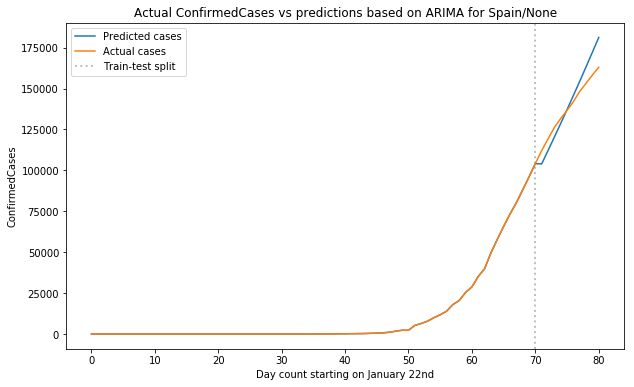

In [31]:
# Define a general function to run ARIMA regression
def arima_cp(all_data, country_name, province_name, target, train_lim, test_lim):
    
    #Select data for the Country/Region, splitting train/test days
    data_cp = all_data.loc[(all_data['Country_Region']==country_dict[country_name]) & (all_data['Province_State']==province_dict[province_name])]
    data_cp_train = data_cp.loc[(data_cp['Day_num'])<=train_lim, target].astype(np.int32)
    data_cp_test = data_cp.loc[(data_cp['Day_num'])>test_lim, target].astype(np.int32)

    # Set the range of parameters to use
    stepwise_model = auto_arima(data_cp[target], start_p=1, start_q=1, max_p=30, max_q=30, 
                                start_P=0, seasonal=False, d=2, trace=False, error_action='ignore', stepwise=True)

    # Train and predict
    stepwise_model.fit(data_cp_train, start_ar_lags=2*max(30, 30))
    forecast = stepwise_model.predict(n_periods=test_lim-train_lim)
    return forecast


# Plot the actual values vs predictions
def plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, target):
    df_train = train.loc[(train['Country_Region']==country_name) & (train['Province_State']==province_name), target]
    df_fcst = np.append(df_train[:-valid_num], forecast[:valid_num])
    dates = list(range(0,len(df_train)))
    
    # Plot results
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))
    ax1.plot(dates, df_fcst)
    ax1.plot(dates, df_train)
    ax1.axvline(len(df_train)-valid_num-1, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.set_title("Actual ConfirmedCases vs predictions based on ARIMA for "+country_name + "/"+province_name)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count starting on January 22nd")
    ax1.set_ylabel("ConfirmedCases")
    
    
    
# Inputs
country_name = 'Spain'
province_name = 'None'
train_lim = 69
valid_lim = 79 # needs to be changed as more days of training data are included
test_lim = 112
valid_num=valid_lim-train_lim 

forecast = arima_cp(all_data, country_name, province_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases')

* **Italy**

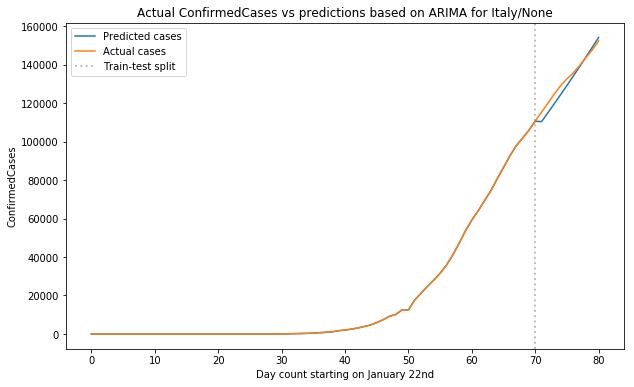

In [32]:
# Inputs
country_name = 'Italy'
province_name = 'None'

forecast = arima_cp(all_data, country_name, province_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases')

* **Germany**

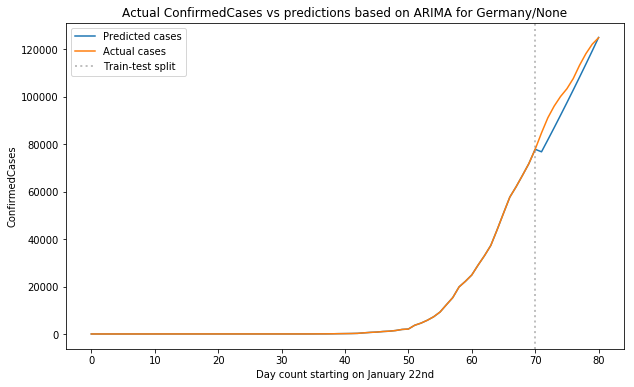

In [33]:
# Inputs
country_name = 'Germany'
province_name = 'None'

forecast = arima_cp(all_data, country_name, province_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases')

* **Albania**

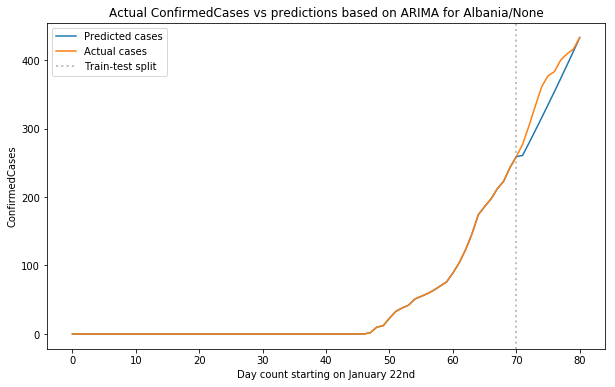

In [34]:
# Inputs
country_name = 'Albania'
province_name = 'None'

forecast = arima_cp(all_data, country_name, province_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases')

* **Norway**

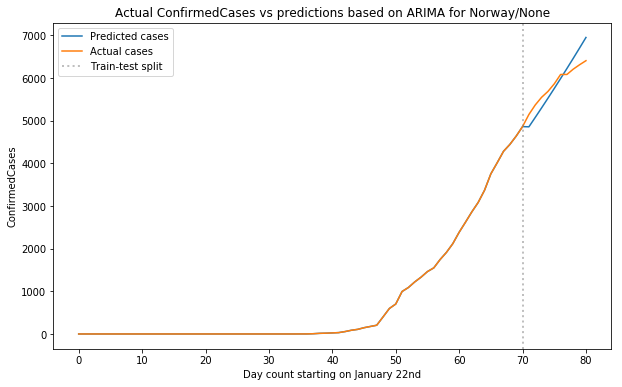

In [35]:
# Inputs
country_name = 'Norway'
province_name = 'None'

forecast = arima_cp(all_data, country_name, province_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases')

* **China/Hubei**

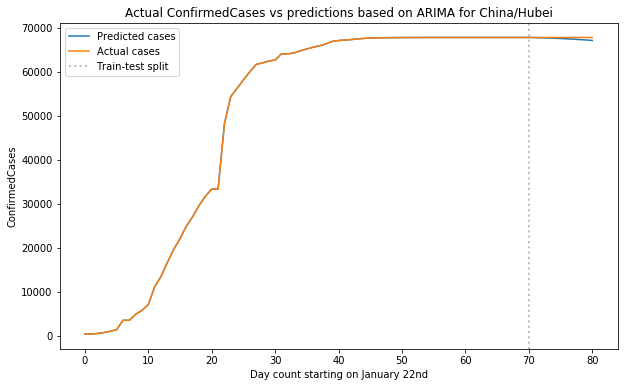

In [36]:
# Inputs
country_name = 'China'
province_name = 'Hubei'

forecast = arima_cp(all_data, country_name, province_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases')